# Libraries

In [1]:
import sys
import os
import gc
import warnings
import random
from copy import deepcopy
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, TensorDataset, DataLoader
from madgrad import MADGRAD, MirrorMADGRAD
from torch.optim import AdamW
from transformers import (
    get_constant_schedule,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_polynomial_decay_schedule_with_warmup
)

from sklearn.model_selection import StratifiedKFold, KFold
    
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

# Load Data

In [2]:
PROJECT_DIR = "."
DATA_DIR = f"{PROJECT_DIR}/data"

In [3]:
train = pd.read_csv(f"{DATA_DIR}/train.csv")
test = pd.read_csv(f"{DATA_DIR}/public_test.csv")
submission = pd.read_csv(f"{DATA_DIR}/sample_submission.csv")

train.head(20)

,corrupted_text,correct_text,category
0,"Считает, что ссожет ить вечно!","Считает, что сможет жить вечно!",phrases
1,20 миллионов и ни ппнни меньше!,20 миллионов и ни пенни меньше!,phrases
2,- Но и мы умрём.,- Но и мы умрём.,phrases
3,Ты вобще молоцд.,Ты вобще молодец.,phrases
4,Вы имеетн в виду силу ьога?,Вы имеете в виду силу бога?,phrases
5,"Я поливала вцеты, я обещала Кауфманам их пaлиать.","Я поливала цветы, я обещала Кауфманам их полив...",phrases
6,"Не обращайте на меня винмнаия, м-р Дженнингс?","Не обращайте на меня внимания, м-р Дженнингс?",phrases
7,босаснов зефир ванильный темной глазури,БоссаНова зефир ванильный темной глазури,products
8,А ночью Джоуи Триббиани!,А ночью Джоуи Триббиани!,phrases
9,Филир Морис комп Эксперт,Филип Морис комп Эксперт,products


In [4]:
test

,corrupted_text
0,"Скажи сыну, тчо всё будет хорош, Гордон."
1,"Лаюно. Отсавайся, сколько хочешь."
2,Почему вы здесь? Прошлой очью я слышаш выстрелы.
3,А какая бла у Джорджи работа в последний дееь?
4,Уош мне родря!
...,...
185048,Мылр горчичное Ивановское
185049,"Хорошо получилось, добрыи сэ. Вы победитель."
185050,Только чтa закончили.
185051,Кого? — Про ког он?


In [5]:
train.category.value_counts()

phrases     1088214
products     369523
jokes         13957
books          8726
Name: category, dtype: int64

# Preprocessing

In [6]:
def preprocessor(text):
    return "".join([char for char in text if char.isalnum() or char == " "])

In [7]:
correct_words = set()

for el in tqdm(train["correct_text"].apply(preprocessor)):
    correct_words.update(set(el.split()))

len(correct_words)

  0%|          | 0/1480420 [00:00<?, ?it/s]

349848

In [8]:
punct = set()

for el in tqdm(train["correct_text"].append(train["corrupted_text"]).append(test["corrupted_text"])):
    for char in el:
        if not char.isalnum():
            punct.add(char)
            
punct

  0%|          | 0/3145893 [00:00<?, ?it/s]

{' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '\xa0',
 '£',
 '¤',
 '§',
 '©',
 '«',
 '¬',
 '\xad',
 '®',
 '°',
 '·',
 '»',
 '÷',
 '́',
 '\u200b',
 '\u200d',
 '‐',
 '–',
 '—',
 '’',
 '‚',
 '“',
 '”',
 '„',
 '•',
 '…',
 '′',
 '€',
 '№',
 '→',
 '∆',
 '√',
 '≈',
 '╣',
 '╧',
 '▒',
 '☁',
 '☪',
 '☼',
 '♔',
 '♪',
 '⚽',
 '⛄',
 '✌',
 '️',
 '\ufeff',
 '🎈',
 '🏆',
 '🏻',
 '🐱',
 '👌',
 '👍',
 '👩',
 '💧',
 '💨',
 '💩',
 '😃',
 '😆',
 '😉',
 '😊',
 '😭',
 '🚴'}

In [9]:
nums = set()

for el in tqdm(train["correct_text"].append(train["corrupted_text"]).append(test["corrupted_text"])):
    for char in el:
        if char.isnumeric():
            # print(el)
            nums.add(char)
            
nums

  0%|          | 0/3145893 [00:00<?, ?it/s]

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [10]:
def encode(text: str) -> tuple:
    q = []
    pos = 0
    words = preprocessor(text).split()

    prev_char_isalnum = 1

    for i in range(len(text)):
        char = text[i]
        char_isalnum = char.isalnum()

        if not prev_char_isalnum and char_isalnum:
            pos += 1

        if not char_isalnum:
            q.append((char, pos))     
        
        prev_char = char
        prev_char_isalnum = char_isalnum

    return words, q


def decode(words, q) -> tuple:
    shift = 1
    
    for el, pos in q:
        words.insert(pos + shift, el)
        shift += 1
    
    return "".join(words)

In [11]:
correct_tokens = []
correct_queues = []

corrupted_tokens = []
corrupted_queues = []

for text in tqdm(train["correct_text"]):
    tokens, queue = encode(text)
    correct_tokens.append(tokens)
    correct_queues.append(queue)

for text in tqdm(train["corrupted_text"]):     
    tokens, queue = encode(text)
    corrupted_tokens.append(tokens)
    corrupted_queues.append(queue)

  0%|          | 0/1480420 [00:00<?, ?it/s]

  0%|          | 0/1480420 [00:00<?, ?it/s]

In [12]:
letter_dataset = []
for i in tqdm(range(len(correct_tokens))):
    for j in range(len(correct_tokens[i])):
        if correct_tokens[i][j] != corrupted_tokens[i][j]:
            letter_dataset.append((correct_tokens[i][j], corrupted_tokens[i][j]))

  0%|          | 0/1480420 [00:00<?, ?it/s]

In [13]:
len(letter_dataset)

2002836

In [14]:
lens = []

for el in tqdm(letter_dataset):
    lens.append(len(el[0]))
    lens.append(len(el[1]))

  0%|          | 0/2002836 [00:00<?, ?it/s]

<AxesSubplot: >

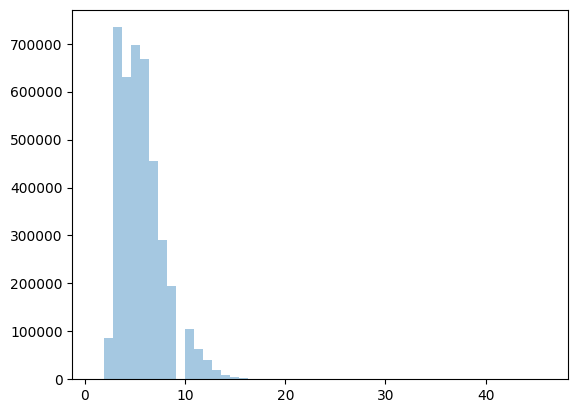

In [15]:
sns.distplot(lens, kde=False)

In [16]:
letter_dataset[lens.index(max(lens)) // 2]

('Зимойнадописатьсловаслитночтобыбуковкинемерзли',
 'зимойнадопихатьсловаслитрчтобыбуковкинемерзли')

In [17]:
clean_dataset = []

for el in tqdm(letter_dataset):
    if (len(el[0]) <= 20 and len(el[1]) <= 20) and el[0].isalpha() and el[1].isalpha():
        clean_dataset.append(el)

len(clean_dataset)

  0%|          | 0/2002836 [00:00<?, ?it/s]

2002451

In [18]:
letters = set()

for el in tqdm(clean_dataset):
    letters.update(set(el[0]))
    letters.update(set(el[1]))

letters

  0%|          | 0/2002451 [00:00<?, ?it/s]

{'A',
 'B',
 'C',
 'D',
 'E',
 'G',
 'H',
 'K',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'V',
 'X',
 'a',
 'b',
 'e',
 'h',
 'i',
 'k',
 'l',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'x',
 'y',
 'ı',
 'ƒ',
 'Ё',
 'Ђ',
 'Ѕ',
 'Ћ',
 'Ќ',
 'Ў',
 'Џ',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 'К',
 'Л',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ц',
 'Ч',
 'Ш',
 'Щ',
 'Ъ',
 'Э',
 'Ю',
 'Я',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 'ѕ',
 'ї',
 'ћ',
 'ќ'}

In [19]:
PAD = 0
CLS = 1
SEP = 2
MAX_LEN = 20

tokenizer_encoder = dict()
tokenizer_decoder = dict()

for i, letter in enumerate(letters):
    tokenizer_encoder[letter] = i + 2
    tokenizer_decoder[i + 2] = letter

tokenizer_encoder

{'ƒ': 2,
 'Д': 3,
 'м': 4,
 'i': 5,
 'Ћ': 6,
 'Џ': 7,
 'ћ': 8,
 'с': 9,
 's': 10,
 'Щ': 11,
 'М': 12,
 'ц': 13,
 'ѕ': 14,
 'П': 15,
 'ъ': 16,
 'y': 17,
 'p': 18,
 'X': 19,
 'р': 20,
 'ф': 21,
 'K': 22,
 'ю': 23,
 'д': 24,
 'Х': 25,
 'Н': 26,
 'r': 27,
 'З': 28,
 'ч': 29,
 'Ў': 30,
 'G': 31,
 'R': 32,
 'й': 33,
 'т': 34,
 'в': 35,
 'я': 36,
 'M': 37,
 'А': 38,
 'N': 39,
 'а': 40,
 'ё': 41,
 'Р': 42,
 'Я': 43,
 'ш': 44,
 'л': 45,
 'ж': 46,
 'k': 47,
 'E': 48,
 'b': 49,
 'e': 50,
 'P': 51,
 'Б': 52,
 'V': 53,
 'Q': 54,
 'ı': 55,
 'ќ': 56,
 'у': 57,
 'u': 58,
 'п': 59,
 'A': 60,
 'ы': 61,
 'ь': 62,
 'ї': 63,
 'Ю': 64,
 'x': 65,
 'и': 66,
 'В': 67,
 'C': 68,
 'Ќ': 69,
 'Ѕ': 70,
 'h': 71,
 'Г': 72,
 'г': 73,
 'a': 74,
 'B': 75,
 'Э': 76,
 'D': 77,
 'Ц': 78,
 'б': 79,
 'n': 80,
 'С': 81,
 'Ж': 82,
 'Е': 83,
 'S': 84,
 'Ъ': 85,
 'Ф': 86,
 'o': 87,
 'Ё': 88,
 't': 89,
 'Й': 90,
 'к': 91,
 'H': 92,
 'е': 93,
 'х': 94,
 'К': 95,
 'щ': 96,
 'O': 97,
 'Л': 98,
 'l': 99,
 'Ч': 100,
 'з': 101,
 'Т': 

In [20]:
def tokenizer_encode(text: str):
    ids = [tokenizer_encoder[letter] for letter in list(text)]
    input_ids = torch.cat(
        [torch.tensor([CLS]), torch.tensor(ids), torch.tensor([PAD]), torch.tensor([PAD] * (MAX_LEN - len(ids)))]
    )
    attention_mask = torch.cat(
        [torch.ones(len(ids) + 2), torch.zeros(MAX_LEN - len(ids))]
    )

    return torch.unsqueeze(input_ids, dim=0), torch.unsqueeze(attention_mask, dim=0)

In [21]:
correct_input_ids = []
corrupted_input_ids = []
correct_attention_mask = []
corrupted_attention_mask = []

for el in tqdm(clean_dataset):
    el_correct_input_ids, el_correct_attention_mask = tokenizer_encode(el[0])
    el_corruptedinput_ids, el_corruptedattention_mask = tokenizer_encode(el[1])

    correct_input_ids.append(el_correct_input_ids)
    corrupted_input_ids.append(el_corruptedinput_ids)
    correct_attention_mask.append(el_correct_attention_mask)
    corrupted_attention_mask.append(el_corruptedattention_mask)


  0%|          | 0/2002451 [00:00<?, ?it/s]

In [22]:
correct_input_ids

[tensor([[  1,   9,   4, 109,  46,  93,  34,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]),
 tensor([[ 1, 46, 66, 34, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]]),
 tensor([[  1,  59,  93, 108, 108,  66,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]),
 tensor([[  1,   4, 109,  45, 109,  24,  93,  13,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]),
 tensor([[ 1, 66,  4, 93, 93, 34, 93,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]]),
 tensor([[  1,  79, 109,  73,  40,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]),
 tensor([[ 1, 13, 35, 93, 34, 61,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]]),
 tensor([[  1,  59, 109,  45,  66,  35,  40,  34,  62,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]),
 t

In [23]:
correct_input_ids = torch.cat(correct_input_ids, dim=0)
corrupted_input_ids = torch.cat(corrupted_input_ids, dim=0)
correct_attention_mask = torch.cat(correct_attention_mask, dim=0)
corrupted_attention_mask = torch.cat(corrupted_attention_mask, dim=0)
corrupted_attention_mask, correct_attention_mask

(tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]))

In [24]:
correct_input_ids = correct_input_ids.long()
corrupted_input_ids = corrupted_input_ids.long()
correct_attention_mask = correct_attention_mask.bool()
corrupted_attention_mask = corrupted_attention_mask.bool()

# Loops

In [72]:
from torch import autocast


def train_epoch(model, data_loader, loss_function, optimizer, scheduler, iters_to_accumulate, device):
    optimizer.zero_grad()
    model.train()
    
    total_train_loss = 0
    total_correct = 0
    batch_i = 0

    dl_size = len(data_loader)

    for batch in tqdm(data_loader):
        b_src, b_trg, b_src_mask, b_trg_mask = batch
        b_src = b_src.to(device)
        b_src_mask = b_src_mask.to(device)
        b_trg = b_trg.to(device)
        b_trg_mask = b_trg_mask.to(device)
        
        optimizer.zero_grad()
#         with torch.autocast(device_type='cuda'):
        logits = model(b_src, b_trg, b_src_mask, b_trg_mask)
        correct_amount = (logits.argmax(dim=2) == b_trg).sum()
        loss = loss_function(logits.reshape(-1, logits.shape[-1]), b_trg.reshape(-1))
        
        if not loss.isnan():
            total_train_loss += loss.item()
            total_correct += correct_amount
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
        else:
            dl_size -= 1

#         scaler.scale(loss).backward()

#         if (batch_i + 1) % iters_to_accumulate == 0:
#             scaler.unscale_(optimizer)
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             scaler.step(optimizer)
#             scaler.update()
        
    
        batch_i += 1

    return total_train_loss / dl_size, total_correct / dl_size
    
    
def eval_epoch(model, data_loader, loss_function, device):
    model.eval()
    total_train_loss = 0
    total_correct = 0


    dl_size = len(data_loader)
    
    for batch in tqdm(data_loader):
        b_src, b_trg, b_src_mask, b_trg_mask = batch
        b_src = b_src.to(device)
        b_src_mask = b_src_mask.to(device)
        b_trg = b_trg.to(device)
        b_trg_mask = b_trg_mask.to(device)
        
        with torch.no_grad():
            logits = model(b_src, b_trg, b_src_mask, b_trg_mask)
#             b_probas = torch.softmax(logits, dim=1)
            correct_amount = (logits.argmax(dim=2) == b_trg).sum()
            loss = loss_function(logits.reshape(-1, logits.shape[-1]), b_trg.reshape(-1))
            
        if not loss.isnan():
            total_train_loss += loss.item()
            total_correct += correct_amount
        else:
            dl_size -= 1
    
    return total_train_loss / dl_size, total_correct / dl_size

In [73]:
from torch.cuda.amp import GradScaler


def cross_validation(project_name,
                     model, 
                     dataset, 
                     loss_function,
                     strat_array=None, 
                     device=torch.device("cpu"),
                     random_state: int=69, 
                     n_folds: int=4, 
                     shuffle: bool=True,
                     epochs: int=5, 
                     lr: float=1e-6,
                     start_fold: int=0, 
                     batch_size: int=32,
                     iters_to_accumulate: int=5):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    if strat_array:
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
    else: 
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)

    for fold, (train_ids, eval_ids) in enumerate(kfold.split(dataset, strat_array)):
        if fold >= start_fold:
            print(f'FOLD {fold}')
            print('--------------------------------')
            
            wandb.init(
                project=f"{project_name}_fold_{fold}",
                config={ 
                         "random_state": random_state, 
                         "shuffle": shuffle,
                         "epochs": epochs, 
                         "learning_rate": lr,
                         "batch_size": batch_size,
                         "iters_to_accumulate": iters_to_accumulate
                        }
            )

            fold_model = deepcopy(model)
            fold_model.to(device)

            optimizer = MADGRAD(
                model.parameters(),
                lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
            )
            
            train_subsampler = torch.utils.data.Subset(dataset,  train_ids)
            train_loader = torch.utils.data.DataLoader(
                          train_subsampler, 
                          batch_size=batch_size)

            eval_subsampler = torch.utils.data.Subset(dataset,  eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                          eval_subsampler,
                          batch_size=batch_size)
            
            total_steps = len(train_loader) * epochs 

            scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

            for epoch_i in range(0, epochs):
                train_acc, train_loss = train_epoch(fold_model, train_loader, loss_function, optimizer, scheduler, iters_to_accumulate, device)
                eval_acc, eval_loss = eval_epoch(fold_model, eval_loader, loss_function, device)
                print(f"EPOCH: {epoch_i}")
                print(f"TRAIN LOSS: {train_loss}")
                print(f"EVAL LOSS:  {eval_loss}")
                
                wandb.log({
                    "train_acc": train_acc, 
                    "eval_acc": eval_acc, 
                    "train_loss": train_loss,
                    "eval_loss": eval_loss
                })
                
                wandb.watch(fold_model)
            
            wandb.finish()



def single_model(model, 
                     dataset, 
                     loss_function, 
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     epochs: int=5, 
                     lr: float=1e-6,
                     batch_size: int=32,
                        
                     ):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    model.to(device)

    optimizer = MADGRAD(
        model.parameters(),
        lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    )

    data_loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size)
    
    total_steps = len(data_loader) * epochs 

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    losses = []

    for epoch_i in range(0, epochs):
        if epoch_i >= start_epoch:
            epoch_path = f"{path}/epoch_{epoch_i}/"
            os.mkdir(epoch_path)

            epoch_loss = train_epoch(model, data_loader, loss_function, optimizer, scheduler, device)
            losses.append(epoch_loss)
            print("EPOCH", epoch_i, epoch_loss)
            
            # eval_epoch(fold_model, eval_loader, loss_function, device)

# Model

In [27]:
class TransformerChar2Vec(nn.Module):
    def __init__(self,      
                 vocab_size,
                 d_model=512,
                 nhead=8, 
                 num_encoder_layers=6, 
                 num_decoder_layers=6, 
                 dim_feedforward=2048, 
                 dropout=0.1, 
                 layer_norm_eps=1e-05, 
                 norm_first=True,
                 batch_first=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.layer_norm_eps = layer_norm_eps
        self.norm_first = norm_first
        self.batch_first = batch_first

        self.embedding = nn.Embedding(vocab_size, self.d_model)

        self.transformer = torch.nn.Transformer(
            d_model=self.d_model, 
            nhead=self.nhead,
            num_encoder_layers=self.num_encoder_layers,
            num_decoder_layers=self.num_decoder_layers,
            dim_feedforward=self.dim_feedforward,
            dropout=self.dropout,
            layer_norm_eps=self.layer_norm_eps,
            norm_first=self.norm_first,
            batch_first=self.batch_first
        )
        
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(self.d_model, self.vocab_size)
    
    def forward(self, src, trg, src_mask, trg_mask):
        src_emb = self.embedding(src)
        trg_emb = self.embedding(trg)

        transformer_output = self.transformer(src_emb, trg_emb, src_key_padding_mask=src_mask, tgt_key_padding_mask=trg_mask)

        transformer_output = self.dropout(transformer_output)
        out = self.out(transformer_output)
        return out



# Loss

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, weights=None, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.weights = weights
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weights)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

# Cross Validation

In [29]:
dataset = TensorDataset(corrupted_input_ids, correct_input_ids, corrupted_attention_mask, correct_attention_mask)

In [30]:
VOCAB_SIZE = len(letters) + 3
model = TransformerChar2Vec(
    vocab_size=VOCAB_SIZE,
    norm_first=True,
    batch_first=True,
)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

loss_function = nn.CrossEntropyLoss(ignore_index=PAD)

In [33]:
!nvidia-smi

Sat Nov 12 20:04:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.06    Driver Version: 520.56.06    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0  On |                  Off |
|  0%   36C    P8    22W / 450W |    387MiB / 24564MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
!free -g

               total        used        free      shared  buff/cache   available
Mem:             125          16         106           0           2         108
Swap:              1           0           1


In [35]:
gc.collect()

490

In [36]:
torch.cuda.empty_cache()

In [70]:
import wandb

In [ ]:
cross_validation(project_name="rucode_6_b",
                 model=model, 
                 dataset=dataset, 
                 loss_function=loss_function,
                 device=torch.device("cuda"),
                 random_state=69, 
                 n_folds=5, 
                 shuffle=True,
                 epochs=15, 
                 lr=1e-6,
                 start_fold=0, 
                 batch_size=64,
                )

FOLD 0
--------------------------------


  0%|          | 0/25031 [00:00<?, ?it/s]

# Prediction

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

In [ ]:
def decorupt(model,  vocab, tokens: list, top_n=100) -> np.ndarray:
    embeddings = model.get_embeddings(tokens)

    for i in range(len(tokens)):
        token = tokens[i]
        print(token)

        if token not in vocab: 
            embedding = embeddings[i]
            substitutes = model.word2vec.most_similar(positive=[embedding], topn=top_n)

            in_vocab = [[substitute[0], distance(substitute[0], token)] for substitute in substitutes if substitute[0] in vocab]
            print(in_vocab, "in vocab")

            in_vocab = sorted(in_vocab, key=lambda x: x[1])
            tokens[i] = in_vocab[0][0]
                    
    
    return tokens